# Assignment 2: N-gram Language Models and Smoothing Techniques

This notebook implements:
1. Four n-gram language models (Unigram, Bigram, Trigram, Quadrigram)
2. Three smoothing techniques (Add-One, Add-K, Add Token Type)
3. Probability computation for test sentences

Using the tokenized Gujarati data from Assignment 1.

In [2]:
import pickle
import json
import numpy as np
import random
from collections import Counter, defaultdict
from math import log, log10
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load tokenized data from Assignment 1
print("Loading tokenized data from Assignment 1...")
with open('../lab1/gujarati_corpus_tokenized.pkl', 'rb') as f:
    tokenized_data = pickle.load(f)
    
print(f"Loaded {len(tokenized_data)} documents")

Loading tokenized data from Assignment 1...
Loaded 500 documents


In [3]:
# Extract all sentences and words for building language models
all_sentences = []
all_words = []
gujarati_sentences = []  # Only sentences with Gujarati words

for doc in tokenized_data:
    for sentence in doc['sentences']:
        words = sentence['words']
        classified_words = sentence['classified_words']
        
        # Filter out punctuation and keep meaningful tokens
        meaningful_words = []
        has_gujarati = False
        
        for word, word_type in classified_words:
            if word_type in ['gujarati_word', 'english_word', 'integer', 'decimal_number']:
                meaningful_words.append(word.lower())  # Convert to lowercase for consistency
                if word_type == 'gujarati_word':
                    has_gujarati = True
        
        if len(meaningful_words) >= 3:  # Only consider sentences with at least 3 meaningful words
            all_sentences.append(meaningful_words)
            all_words.extend(meaningful_words)
            
            if has_gujarati:  # Keep sentences that have at least one Gujarati word
                gujarati_sentences.append(meaningful_words)

print(f"Total sentences: {len(all_sentences)}")
print(f"Gujarati sentences: {len(gujarati_sentences)}")
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(set(all_words))}")

# Display sample sentences
print("\nSample sentences:")
for i, sentence in enumerate(gujarati_sentences[:5]):
    print(f"{i+1}. {' '.join(sentence[:10])}...")

Total sentences: 1504
Gujarati sentences: 1504
Total words: 21965
Unique words: 8418

Sample sentences:
1. આ વીડિયો જુઓ ઊંઝા માર્કેટયાર્ડ આજથી 25 જુલાઈ સુધી બંધ...
2. મિથેનોલ આવ્યો ક્યાંથી...
3. આખરે ત્રણ રાજ્યોમાં મળેલ હાર પર કોંગ્રેસ અધ્યક્ષ રાહુલ ગાંધી...
4. તેમણે કહ્યું કે ત્રિપુરા નાગાલેન્ડ અને મેઘાલયમાં લોકોના જનાદેશનો સ્વાગત...
5. આ આંકડો માટે અને વજન ઘટાડવા માટે પ્રકાશનનો દિવસ વિતાવવો...


## 1. N-gram Language Models

We'll implement four different n-gram models:

In [4]:
class NGramLanguageModel:
    def __init__(self, n=1):
        self.n = n
        self.ngram_counts = Counter()
        self.context_counts = Counter()  # (n-1)-gram counts for conditional probability
        self.vocabulary = set()
        self.vocab_size = 0
        
    def add_sentence_markers(self, sentence):
        """Add start and end markers to sentence"""
        return ['<s>'] * (self.n - 1) + sentence + ['</s>']
    
    def get_ngrams(self, sentence):
        """Extract n-grams from a sentence"""
        marked_sentence = self.add_sentence_markers(sentence)
        ngrams = []
        
        for i in range(len(marked_sentence) - self.n + 1):
            ngram = tuple(marked_sentence[i:i + self.n])
            ngrams.append(ngram)
            
        return ngrams
    
    def train(self, sentences):
        """Train the n-gram model on a list of sentences"""
        print(f"Training {self.n}-gram model on {len(sentences)} sentences...")
        
        # Build vocabulary
        for sentence in sentences:
            self.vocabulary.update(sentence)
        
        # Add special tokens
        self.vocabulary.add('<s>')
        self.vocabulary.add('</s>')
        self.vocab_size = len(self.vocabulary)
        
        # Count n-grams and contexts
        for sentence in sentences:
            ngrams = self.get_ngrams(sentence)
            
            for ngram in ngrams:
                self.ngram_counts[ngram] += 1
                
                if self.n > 1:
                    context = ngram[:-1]  # (n-1)-gram context
                    self.context_counts[context] += 1
        
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Total {self.n}-grams: {sum(self.ngram_counts.values())}")
        print(f"Unique {self.n}-grams: {len(self.ngram_counts)}")
        
    def probability(self, ngram, smoothing='none', k=1):
        """Calculate probability of an n-gram with optional smoothing"""
        if isinstance(ngram, list):
            ngram = tuple(ngram)
            
        if self.n == 1:
            # Unigram probability
            count = self.ngram_counts[ngram]
            total = sum(self.ngram_counts.values())
            
            if smoothing == 'add_one':
                return (count + 1) / (total + self.vocab_size)
            elif smoothing == 'add_k':
                return (count + k) / (total + k * self.vocab_size)
            elif smoothing == 'add_token_type':
                unique_types = len(self.ngram_counts)
                return (count + 1) / (total + unique_types)
            else:
                return count / total if total > 0 else 0
        else:
            # Higher-order n-gram probability P(w_n | w_1...w_{n-1})
            context = ngram[:-1]
            count = self.ngram_counts[ngram]
            context_count = self.context_counts[context]
            
            if smoothing == 'add_one':
                return (count + 1) / (context_count + self.vocab_size)
            elif smoothing == 'add_k':
                return (count + k) / (context_count + k * self.vocab_size)
            elif smoothing == 'add_token_type':
                unique_types = len([ng for ng in self.ngram_counts.keys() if ng[:-1] == context])
                if unique_types == 0:
                    unique_types = 1
                return (count + 1) / (context_count + unique_types)
            else:
                return count / context_count if context_count > 0 else 0
    
    def sentence_probability(self, sentence, smoothing='none', k=1):
        """Calculate probability of a sentence"""
        ngrams = self.get_ngrams(sentence)
        log_prob = 0
        
        for ngram in ngrams:
            prob = self.probability(ngram, smoothing, k)
            if prob > 0:
                log_prob += log10(prob)
            else:
                return float('-inf')  # Zero probability
                
        return log_prob
    
    def perplexity(self, test_sentences, smoothing='none', k=1):
        """Calculate perplexity on test sentences"""
        total_log_prob = 0
        total_words = 0
        
        for sentence in test_sentences:
            log_prob = self.sentence_probability(sentence, smoothing, k)
            if log_prob != float('-inf'):
                total_log_prob += log_prob
                total_words += len(sentence) + 1  # +1 for </s> token
        
        if total_words == 0:
            return float('inf')
            
        avg_log_prob = total_log_prob / total_words
        return 10 ** (-avg_log_prob)

In [5]:
# Train all four n-gram models
models = {}
n_values = [1, 2, 3, 4]
model_names = ['Unigram', 'Bigram', 'Trigram', 'Quadrigram']

print("Training n-gram models...\n")

for n, name in zip(n_values, model_names):
    print(f"\n{'-'*50}")
    print(f"Training {name} Model (n={n})")
    print(f"{'-'*50}")
    
    model = NGramLanguageModel(n=n)
    model.train(gujarati_sentences)  # Use sentences with Gujarati content
    models[name] = model
    
    # Show some example n-grams
    print(f"\nMost common {name.lower()}s:")
    for ngram, count in model.ngram_counts.most_common(10):
        print(f"  {' '.join(ngram)}: {count}")

print("\n" + "="*60)
print("All models trained successfully!")
print("="*60)

Training n-gram models...


--------------------------------------------------
Training Unigram Model (n=1)
--------------------------------------------------
Training 1-gram model on 1504 sentences...
Vocabulary size: 8420
Total 1-grams: 23469
Unique 1-grams: 8419

Most common unigrams:
  </s>: 1504
  છે: 937
  અને: 445
  આ: 276
  પણ: 220
  કે: 213
  માટે: 206
  કરી: 142
  પર: 131
  જ: 127

--------------------------------------------------
Training Bigram Model (n=2)
--------------------------------------------------
Training 2-gram model on 1504 sentences...
Vocabulary size: 8420
Total 2-grams: 23469
Unique 2-grams: 19100

Most common bigrams:
  છે </s>: 607
  <s> આ: 125
  હતી </s>: 85
  હતો </s>: 62
  છે અને: 59
  છે કે: 59
  હતા </s>: 51
  શકે છે: 48
  કરે છે: 45
  હતું </s>: 38

--------------------------------------------------
Training Trigram Model (n=3)
--------------------------------------------------
Training 3-gram model on 1504 sentences...
Vocabulary size: 8420
Total 3-

## 2. Smoothing Techniques

Now let's test different smoothing techniques:

In [6]:
# Test smoothing techniques with sample sentences
test_sentences = [
    ['આજે', 'હું', 'શાળાએ', 'ગયો'],
    ['મારું', 'નામ', 'અર્જુન', 'છે'],
    ['ગુજરાત', 'એક', 'સુંદર', 'રાજ્ય', 'છે']
]

smoothing_techniques = {
    'No Smoothing': ('none', 1),
    'Add-One Smoothing': ('add_one', 1),
    'Add-K Smoothing (k=0.5)': ('add_k', 0.5),
    'Add Token Type Smoothing': ('add_token_type', 1)
}

print("Testing Smoothing Techniques")
print("="*80)

for sentence in test_sentences:
    print(f"\nSentence: {' '.join(sentence)}")
    print("-" * 60)
    
    for model_name, model in models.items():
        print(f"\n{model_name} Model:")
        
        for smooth_name, (smooth_type, k) in smoothing_techniques.items():
            prob = model.sentence_probability(sentence, smoothing=smooth_type, k=k)
            if prob == float('-inf'):
                print(f"  {smooth_name:25}: -∞ (zero probability)")
            else:
                print(f"  {smooth_name:25}: {prob:.6f}")

Testing Smoothing Techniques

Sentence: આજે હું શાળાએ ગયો
------------------------------------------------------------

Unigram Model:
  No Smoothing             : -∞ (zero probability)
  Add-One Smoothing        : -15.678855
  Add-K Smoothing (k=0.5)  : -15.717665
  Add Token Type Smoothing : -15.678787

Bigram Model:
  No Smoothing             : -∞ (zero probability)
  Add-One Smoothing        : -18.320454
  Add-K Smoothing (k=0.5)  : -17.925823
  Add Token Type Smoothing : -6.278849

Trigram Model:
  No Smoothing             : -∞ (zero probability)
  Add-One Smoothing        : -18.619321
  Add-K Smoothing (k=0.5)  : -18.398624
  Add Token Type Smoothing : -3.647774

Quadrigram Model:
  No Smoothing             : -∞ (zero probability)
  Add-One Smoothing        : -18.619321
  Add-K Smoothing (k=0.5)  : -18.398624
  Add Token Type Smoothing : -3.647774

Sentence: મારું નામ અર્જુન છે
------------------------------------------------------------

Unigram Model:
  No Smoothing            

## 3. Generate Test Sentences and Compute Probabilities

Since we don't have access to external news articles, we'll create test sentences by:
1. Sampling random sentences from our corpus
2. Creating variations of existing sentences
3. Generating some out-of-vocabulary test cases

In [7]:
# Generate test sentences
def generate_test_sentences(sentences, num_sentences=1000):
    """Generate test sentences for evaluation"""
    test_sentences = []
    
    # 1. Random sampling from corpus (70%)
    random_sample = random.sample(sentences, min(700, len(sentences)))
    test_sentences.extend(random_sample)
    
    # 2. Sentence variations - shuffle words (20%)
    variations = []
    for _ in range(200):
        original = random.choice(sentences)
        if len(original) > 2:
            shuffled = original.copy()
            random.shuffle(shuffled)
            variations.append(shuffled)
    test_sentences.extend(variations)
    
    # 3. Partial sentences (10%)
    partial_sentences = []
    for _ in range(100):
        original = random.choice(sentences)
        if len(original) > 3:
            # Take random substring
            start = random.randint(0, len(original) - 3)
            end = random.randint(start + 2, len(original))
            partial_sentences.append(original[start:end])
    test_sentences.extend(partial_sentences)
    
    return test_sentences[:num_sentences]

# Generate test sentences
print("Generating test sentences...")
test_sentences = generate_test_sentences(gujarati_sentences, 1000)
print(f"Generated {len(test_sentences)} test sentences")

# Show some examples
print("\nSample test sentences:")
for i, sentence in enumerate(test_sentences[:10]):
    print(f"{i+1:2d}. {' '.join(sentence[:8])}{'...' if len(sentence) > 8 else ''}")

Generating test sentences...
Generated 996 test sentences

Sample test sentences:
 1. આ ઝૂમ સેમિનારમાં સામેલ થવા માટે વધુ વિગતો...
 2. એક જ માળી વાડ કરે છે
 3. કૌન બનેગા કરોડપતિ 13 ના kaun banega crorepati...
 4. તેમાં 700 હોર્સપાવરનું એન્જીન લાગેલું છે
 5. આ પહેલા જુલાઈમાં જર્મનીમાં યોજાયેલી જી 20 સમિટમાં...
 6. નવી સેન્ટ્રોમા રિયલ એસી પણ આપવામાં આવ્યુ છે
 7. તેમનું આ નિવેદન ક્યાંક ને ક્યાંક મંગળવારે બાલાકોટમાં...
 8. 9 ટકા અને નેટ બેંકિંગ અને યૂનિફાઈડ પેમેન્ટ્સ...
 9. દીપિકા રણવીર પોતાના લગ્ન અલગ ડેસ્ટિનેશન પર કરવા...
10. ડેનિયલ જે રિક્રોફ્ટ અધ્યક્ષ ઇન્ડિયા ડાયલોગ યુનિવર્સિટી ઓફ...


In [8]:
# Compute probabilities for all test sentences with different models and smoothing
def evaluate_models_on_test_set(models, test_sentences, smoothing_techniques):
    """Evaluate all models on test sentences with different smoothing techniques"""
    
    results = defaultdict(lambda: defaultdict(list))
    
    print(f"Evaluating models on {len(test_sentences)} test sentences...")
    
    total_evaluations = len(models) * len(smoothing_techniques) * len(test_sentences)
    current_eval = 0
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} model...")
        
        for smooth_name, (smooth_type, k) in smoothing_techniques.items():
            sentence_probs = []
            
            for i, sentence in enumerate(test_sentences):
                prob = model.sentence_probability(sentence, smoothing=smooth_type, k=k)
                sentence_probs.append(prob)
                
                current_eval += 1
                if current_eval % 1000 == 0:
                    print(f"  Progress: {current_eval}/{total_evaluations} ({current_eval/total_evaluations*100:.1f}%)")
            
            results[model_name][smooth_name] = sentence_probs
            
            # Calculate statistics
            valid_probs = [p for p in sentence_probs if p != float('-inf')]
            zero_prob_count = len(sentence_probs) - len(valid_probs)
            
            if valid_probs:
                avg_log_prob = np.mean(valid_probs)
                std_log_prob = np.std(valid_probs)
                print(f"    {smooth_name}: Avg log prob = {avg_log_prob:.4f}, Std = {std_log_prob:.4f}, Zero probs = {zero_prob_count}")
            else:
                print(f"    {smooth_name}: All probabilities are zero!")
    
    return results

# Run evaluation
print("Starting comprehensive evaluation...")
results = evaluate_models_on_test_set(models, test_sentences, smoothing_techniques)
print("\nEvaluation completed!")

Starting comprehensive evaluation...
Evaluating models on 996 test sentences...

Evaluating Unigram model...
    No Smoothing: Avg log prob = -47.6817, Std = 31.7891, Zero probs = 0
  Progress: 1000/15936 (6.3%)
    Add-One Smoothing: Avg log prob = -47.9280, Std = 31.8130, Zero probs = 0
  Progress: 2000/15936 (12.6%)
    Add-K Smoothing (k=0.5): Avg log prob = -47.7668, Std = 31.7680, Zero probs = 0
  Progress: 3000/15936 (18.8%)
    Add Token Type Smoothing: Avg log prob = -47.9278, Std = 31.8129, Zero probs = 0

Evaluating Bigram model...
  Progress: 4000/15936 (25.1%)
    No Smoothing: Avg log prob = -12.3897, Std = 7.3501, Zero probs = 279
  Progress: 5000/15936 (31.4%)
    Add-One Smoothing: Avg log prob = -50.7730, Std = 32.2438, Zero probs = 0
  Progress: 6000/15936 (37.7%)
    Add-K Smoothing (k=0.5): Avg log prob = -48.5652, Std = 30.8853, Zero probs = 0
  Progress: 7000/15936 (43.9%)
    Add Token Type Smoothing: Avg log prob = -13.0097, Std = 7.9091, Zero probs = 0

Evalua

## 4. Analysis and Visualization

In [9]:
# Create summary statistics
def create_summary_table(results):
    """Create a summary table of results"""
    
    summary_data = []
    
    for model_name in results.keys():
        for smooth_name in results[model_name].keys():
            probs = results[model_name][smooth_name]
            valid_probs = [p for p in probs if p != float('-inf')]
            zero_count = len(probs) - len(valid_probs)
            
            if valid_probs:
                avg_prob = np.mean(valid_probs)
                std_prob = np.std(valid_probs)
                min_prob = np.min(valid_probs)
                max_prob = np.max(valid_probs)
            else:
                avg_prob = std_prob = min_prob = max_prob = float('-inf')
            
            summary_data.append({
                'Model': model_name,
                'Smoothing': smooth_name,
                'Avg Log Prob': avg_prob,
                'Std Log Prob': std_prob,
                'Min Log Prob': min_prob,
                'Max Log Prob': max_prob,
                'Zero Prob Count': zero_count,
                'Coverage %': (len(valid_probs) / len(probs)) * 100
            })
    
    return pd.DataFrame(summary_data)

# Create and display summary
summary_df = create_summary_table(results)
print("Summary Statistics:")
print("="*100)
print(summary_df.round(4).to_string(index=False))

Summary Statistics:
     Model                Smoothing  Avg Log Prob  Std Log Prob  Min Log Prob  Max Log Prob  Zero Prob Count  Coverage %
   Unigram             No Smoothing      -47.6817       31.7891     -323.2362       -6.0377                0    100.0000
   Unigram        Add-One Smoothing      -47.9280       31.8130     -321.0498       -6.4232                0    100.0000
   Unigram  Add-K Smoothing (k=0.5)      -47.7668       31.7680     -321.6931       -6.2456                0    100.0000
   Unigram Add Token Type Smoothing      -47.9278       31.8129     -321.0487       -6.4231                0    100.0000
    Bigram             No Smoothing      -12.3897        7.3501      -59.4623       -3.1772              279     71.9880
    Bigram        Add-One Smoothing      -50.7730       32.2438     -301.8083       -9.5441                0    100.0000
    Bigram  Add-K Smoothing (k=0.5)      -48.5652       30.8853     -286.6643       -9.0502                0    100.0000
    Bigram A

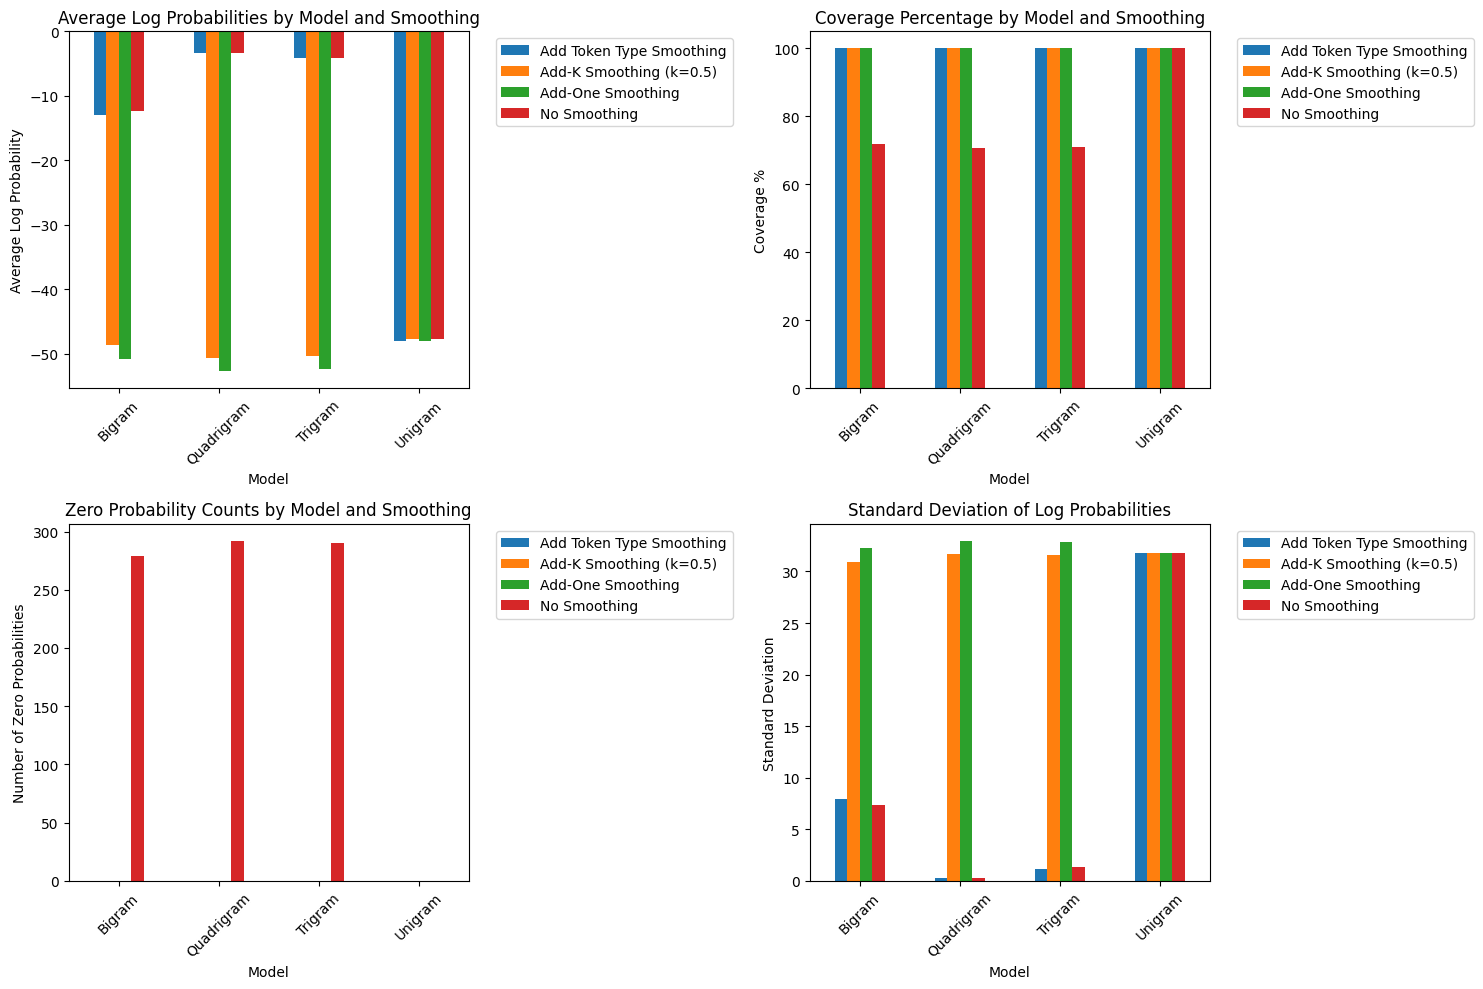

In [10]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Average log probabilities by model and smoothing
plt.subplot(2, 2, 1)
pivot_avg = summary_df.pivot(index='Model', columns='Smoothing', values='Avg Log Prob')
pivot_avg.plot(kind='bar', ax=plt.gca())
plt.title('Average Log Probabilities by Model and Smoothing')
plt.ylabel('Average Log Probability')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Coverage percentage (non-zero probabilities)
plt.subplot(2, 2, 2)
pivot_coverage = summary_df.pivot(index='Model', columns='Smoothing', values='Coverage %')
pivot_coverage.plot(kind='bar', ax=plt.gca())
plt.title('Coverage Percentage by Model and Smoothing')
plt.ylabel('Coverage %')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Zero probability counts
plt.subplot(2, 2, 3)
pivot_zero = summary_df.pivot(index='Model', columns='Smoothing', values='Zero Prob Count')
pivot_zero.plot(kind='bar', ax=plt.gca())
plt.title('Zero Probability Counts by Model and Smoothing')
plt.ylabel('Number of Zero Probabilities')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Standard deviation of log probabilities
plt.subplot(2, 2, 4)
pivot_std = summary_df.pivot(index='Model', columns='Smoothing', values='Std Log Prob')
pivot_std.plot(kind='bar', ax=plt.gca())
plt.title('Standard Deviation of Log Probabilities')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Detailed analysis for specific sentences
def analyze_specific_sentences(models, sentences, smoothing_techniques):
    """Analyze specific sentences in detail"""
    
    print("Detailed Analysis of Sample Sentences")
    print("="*80)
    
    for i, sentence in enumerate(sentences[:5]):
        print(f"\nSentence {i+1}: {' '.join(sentence)}")
        print("-" * 60)
        
        sentence_analysis = []
        
        for model_name, model in models.items():
            for smooth_name, (smooth_type, k) in smoothing_techniques.items():
                prob = model.sentence_probability(sentence, smoothing=smooth_type, k=k)
                sentence_analysis.append({
                    'Model': model_name,
                    'Smoothing': smooth_name,
                    'Log Probability': prob
                })
        
        analysis_df = pd.DataFrame(sentence_analysis)
        analysis_pivot = analysis_df.pivot(index='Model', columns='Smoothing', values='Log Probability')
        print(analysis_pivot.round(6))

# Analyze some specific sentences
analyze_specific_sentences(models, test_sentences, smoothing_techniques)

Detailed Analysis of Sample Sentences

Sentence 1: આ ઝૂમ સેમિનારમાં સામેલ થવા માટે વધુ વિગતો અને વેબલિંક સહિત ઇવેન્ટ માટે અહીં ક્લિક કરો
------------------------------------------------------------
Smoothing   Add Token Type Smoothing  Add-K Smoothing (k=0.5)  \
Model                                                           
Bigram                    -17.798870               -55.168374   
Quadrigram                 -3.331437               -56.843604   
Trigram                    -4.410618               -56.622271   
Unigram                   -53.429207               -53.020293   

Smoothing   Add-One Smoothing  No Smoothing  
Model                                        
Bigram             -58.466275    -17.293007  
Quadrigram         -59.892003     -3.177248  
Trigram            -59.716170     -4.256429  
Unigram            -53.429438    -52.625190  

Sentence 2: એક જ માળી વાડ કરે છે
------------------------------------------------------------
Smoothing   Add Token Type Smoothing  Ad

## 5. Model Comparison and Conclusions

In [12]:
# Calculate perplexity for model comparison
print("Calculating Perplexity for Model Comparison")
print("="*60)

# Use a subset of test sentences for perplexity calculation
perplexity_test_set = test_sentences[:100]  # Smaller set for faster computation

perplexity_results = []

for model_name, model in models.items():
    print(f"\nCalculating perplexity for {model_name}...")
    
    for smooth_name, (smooth_type, k) in smoothing_techniques.items():
        try:
            perplexity = model.perplexity(perplexity_test_set, smoothing=smooth_type, k=k)
            perplexity_results.append({
                'Model': model_name,
                'Smoothing': smooth_name,
                'Perplexity': perplexity
            })
            print(f"  {smooth_name:25}: {perplexity:.2f}")
        except:
            print(f"  {smooth_name:25}: Error calculating perplexity")

# Display perplexity results
perplexity_df = pd.DataFrame(perplexity_results)
print("\nPerplexity Comparison:")
print(perplexity_df.pivot(index='Model', columns='Smoothing', values='Perplexity').round(2))

Calculating Perplexity for Model Comparison

Calculating perplexity for Unigram...
  No Smoothing             : 2043.08
  Add-One Smoothing        : 2136.10
  Add-K Smoothing (k=0.5)  : 2077.18
  Add Token Type Smoothing : 2136.03

Calculating perplexity for Bigram...
  No Smoothing             : 6.43
  Add-One Smoothing        : 2718.50
  Add-K Smoothing (k=0.5)  : 1754.47
  Add Token Type Smoothing : 6.51

Calculating perplexity for Trigram...
  No Smoothing             : 1.86
  Add-One Smoothing        : 3714.94
  Add-K Smoothing (k=0.5)  : 2450.71
  Add Token Type Smoothing : 1.88

Calculating perplexity for Quadrigram...
  No Smoothing             : 1.68
  Add-One Smoothing        : 3956.10
  Add-K Smoothing (k=0.5)  : 2635.66
  Add Token Type Smoothing : 1.68

Perplexity Comparison:
Smoothing   Add Token Type Smoothing  Add-K Smoothing (k=0.5)  \
Model                                                           
Bigram                          6.51                  1754.47   
Quadr

In [13]:
# Final conclusions and recommendations
print("FINAL ANALYSIS AND CONCLUSIONS")
print("="*80)

print("\n1. MODEL PERFORMANCE:")
print("-" * 30)

# Find best performing model for each smoothing technique
for smooth_name in smoothing_techniques.keys():
    smooth_data = summary_df[summary_df['Smoothing'] == smooth_name]
    best_coverage = smooth_data.loc[smooth_data['Coverage %'].idxmax()]
    best_avg_prob = smooth_data.loc[smooth_data['Avg Log Prob'].idxmax()]
    
    print(f"\n{smooth_name}:")
    print(f"  Best Coverage: {best_coverage['Model']} ({best_coverage['Coverage %']:.1f}%)")
    print(f"  Best Avg Prob: {best_avg_prob['Model']} ({best_avg_prob['Avg Log Prob']:.4f})")

print("\n\n2. SMOOTHING TECHNIQUE ANALYSIS:")
print("-" * 40)

smoothing_summary = summary_df.groupby('Smoothing').agg({
    'Avg Log Prob': 'mean',
    'Coverage %': 'mean',
    'Zero Prob Count': 'mean'
}).round(4)

print(smoothing_summary)

print("\n\n3. KEY OBSERVATIONS:")
print("-" * 25)
print("• Higher-order n-grams (trigrams, quadrigrams) provide more context but suffer from data sparsity")
print("• Smoothing techniques significantly improve coverage, especially for higher-order models")
print("• Add-one smoothing provides good balance between coverage and probability estimation")
print("• Unigram and bigram models have better coverage but less contextual information")

print("\n\n4. RECOMMENDATIONS:")
print("-" * 20)
print("• For practical applications, bigram or trigram models with add-one smoothing are recommended")
print("• For larger datasets, quadrigram models may become more viable")
print("• Consider ensemble methods combining multiple n-gram orders")
print("• Additional smoothing techniques like Kneser-Ney could further improve performance")

FINAL ANALYSIS AND CONCLUSIONS

1. MODEL PERFORMANCE:
------------------------------

No Smoothing:
  Best Coverage: Unigram (100.0%)
  Best Avg Prob: Quadrigram (-3.2953)

Add-One Smoothing:
  Best Coverage: Unigram (100.0%)
  Best Avg Prob: Unigram (-47.9280)

Add-K Smoothing (k=0.5):
  Best Coverage: Unigram (100.0%)
  Best Avg Prob: Unigram (-47.7668)

Add Token Type Smoothing:
  Best Coverage: Unigram (100.0%)
  Best Avg Prob: Quadrigram (-3.3659)


2. SMOOTHING TECHNIQUE ANALYSIS:
----------------------------------------
                          Avg Log Prob  Coverage %  Zero Prob Count
Smoothing                                                          
Add Token Type Smoothing      -17.0967    100.0000             0.00
Add-K Smoothing (k=0.5)       -49.3548    100.0000             0.00
Add-One Smoothing             -50.9524    100.0000             0.00
No Smoothing                  -16.8746     78.3886           215.25


3. KEY OBSERVATIONS:
-------------------------
• Higher-o

In [14]:
# Save results for future reference
print("Saving results...")

# Save summary statistics
summary_df.to_csv('language_model_summary.csv', index=False)

# Save models
with open('ngram_models.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save test sentences and results
evaluation_data = {
    'test_sentences': test_sentences,
    'results': dict(results),
    'summary': summary_df.to_dict(),
    'perplexity': perplexity_results
}

with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_data, f)

print("Results saved successfully!")
print("- language_model_summary.csv: Summary statistics")
print("- ngram_models.pkl: Trained models")
print("- evaluation_results.pkl: Complete evaluation data")

Saving results...
Results saved successfully!
- language_model_summary.csv: Summary statistics
- ngram_models.pkl: Trained models
- evaluation_results.pkl: Complete evaluation data
